In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, cross_val_score
# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
# skopt
from skopt import BayesSearchCV

#helpers
import helpers

In [2]:
results = pd.DataFrame({'hiperparametry': [], 'wynik_zbior_1': [], 'wynik_zbior_2': [], 'wynik_zbior_3': [], 'wynik_zbior_4': [], 'model': []})

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
RANDOM_STATE = 123

In [5]:
# Load datasets
import warnings
warnings.filterwarnings('ignore')

Xs = []
ys = []

df_1 = fetch_openml(data_id=31)
df_2 = fetch_openml(data_id=1489)
df_3 = fetch_openml(data_id=1558)
df_4 = fetch_openml(data_id=183)

X_1 = df_1.data
y_1 = df_1.target
Xs.append(X_1)
ys.append(y_1)

X_2 = df_2.data
y_2 = df_2.target
Xs.append(X_2)
ys.append(y_2)

X_3 = df_3.data
y_3 = df_3.target
Xs.append(X_3)
ys.append(y_3)

X_4 = df_3.data
y_4 = df_3.target
Xs.append(X_4)
ys.append(y_4)

warnings.filterwarnings('default')

In [6]:
# split datasets into train and test
X_train_arr = []
X_test_arr = []
y_train_arr = []
y_test_arr = []
cols_num = []
cols_cat = []

for i in range(len(Xs)):
    X_train, X_test, y_train, y_test = train_test_split(Xs[i], ys[i], test_size=0.3, random_state=RANDOM_STATE)

    X_train_arr.append(X_train)
    X_test_arr.append(X_test)
    y_train_arr.append(y_train)
    y_test_arr.append(y_test)

    numeric_features = X_train_arr[i].select_dtypes(exclude=['category']).columns
    categorical_features = X_train_arr[i].select_dtypes(include=['category']).columns

    cols_num.append(numeric_features)
    cols_cat.append(categorical_features)

In [7]:
# helper function to wrap model and do imputing and encoding

def getPipeline(model, num_cols, cat_cols):
    numeric_transformer = Pipeline(
        steps=[("imputer", SimpleImputer(strategy="median"))]
    )

    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy='most_frequent')),
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, num_cols),
            ("cat", categorical_transformer, cat_cols),
        ]
    )

    pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", model)]
    )

    return pipe

### Parameters grid

In [32]:
grid_log_reg = {
    'classifier__C': np.logspace(-4, 4, 50),
    'classifier__l1_ratio': np.linspace(0, 1, 50)
}

grid_tree = {
    'classifier__max_depth': np.concatenate(([None], range(5, 100, 5))),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(2, 50, 2)),
    'classifier__max_leaf_nodes': np.concatenate(([None], range(30, 330, 30))),
    'classifier__ccp_alpha': np.logspace(-3, 3, 50)
}

grid_forest = {
    'classifier__max_depth': np.concatenate(([None], range(1, 11, 1))),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(2, 10, 1)),
    'classifier__max_leaf_nodes': np.concatenate(([None], range(2, 50, 1))),
    'classifier__ccp_alpha': np.logspace(-3, 2, 50),
    'classifier__bootstrap': [True, False],
    'classifier__warm_start': [True, False]
}

In [9]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

### Important helpers. They Return best CV scores and params for each set

In [10]:
def getRandomCVResults(model, grid, n_iter=10, n_jobs=1, verbose=0):
    search_res = []
    for i in range(len(X_train_arr)):
        clf = getPipeline(model, cols_num[i], cols_cat[i])

        res = RandomizedSearchCV(clf, param_distributions=grid, random_state=RANDOM_STATE, cv=cv, scoring='accuracy', n_iter=n_iter, n_jobs=n_jobs, verbose=verbose)
        res.fit(X_train_arr[i], y_train_arr[i])

        search_res.append(res)
        print(f"Fit for set number {i} is done")
        
    return search_res

def getBayesCVResults(model, grid, n_iter=10, n_jobs=1, verbose=0):
    search_res = []
    for i in range(len(X_train_arr)):
        clf = getPipeline(model, cols_num[i], cols_cat[i])

        res = BayesSearchCV(clf, search_spaces=grid, cv=cv, scoring='accuracy', n_iter=n_iter, n_jobs=n_jobs, verbose=verbose)
        res.fit(X_train_arr[i], y_train_arr[i])
        search_res.append(res)
        print(f"Fit for set number {i} is done")
    
    return search_res


# Logistic Regression

### Look for best hyperparams (Random search method) for each set

In [11]:
warnings.filterwarnings('ignore')

lr = LogisticRegression(penalty='elasticnet', solver='saga', random_state=RANDOM_STATE, max_iter=1000)
search_rand_lr = getRandomCVResults(lr, grid_log_reg, 5, -1)

warnings.filterwarnings('default')

In [40]:
res_lr = {
    'hiperparametry': search_rand_lr[0].cv_results_['params'], 
    'wynik_zbior_1': search_rand_lr[0].cv_results_['mean_test_score'], 
    'wynik_zbior_2': search_rand_lr[1].cv_results_['mean_test_score'], 
    'wynik_zbior_3': search_rand_lr[2].cv_results_['mean_test_score'], 
    'wynik_zbior_4': search_rand_lr[3].cv_results_['mean_test_score']
}

results_lr = pd.DataFrame(res_lr)
results_lr['model'] = 'LogisticRegression'

# Decision Tree

In [35]:
#warnings.filterwarnings('ignore')

tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
search_rand_tree = getRandomCVResults(tree, grid_tree, 5, -1)

#warnings.filterwarnings('default')

In [43]:
res_tree = {
    'hiperparametry': search_rand_tree[0].cv_results_['params'], 
    'wynik_zbior_1': search_rand_tree[0].cv_results_['mean_test_score'], 
    'wynik_zbior_2': search_rand_tree[1].cv_results_['mean_test_score'], 
    'wynik_zbior_3': search_rand_tree[2].cv_results_['mean_test_score'], 
    'wynik_zbior_4': search_rand_tree[3].cv_results_['mean_test_score']
}

results_tree = pd.DataFrame(res_tree)
results_tree['model'] = 'DecisionTreeClassifier'

# Random Forest

In [34]:
#warnings.filterwarnings('ignore')

forest = RandomForestClassifier(random_state=RANDOM_STATE)
search_rand_forest = getRandomCVResults(forest, grid_forest, 5, -1)

#warnings.filterwarnings('default')

In [44]:
res_forest = {
    'hiperparametry': search_rand_forest[0].cv_results_['params'], 
    'wynik_zbior_1': search_rand_forest[0].cv_results_['mean_test_score'], 
    'wynik_zbior_2': search_rand_forest[1].cv_results_['mean_test_score'], 
    'wynik_zbior_3': search_rand_forest[2].cv_results_['mean_test_score'], 
    'wynik_zbior_4': search_rand_forest[3].cv_results_['mean_test_score']
}

results_forest = pd.DataFrame(res_forest)
results_forest['model'] = 'RandomForestClassifier'

In [38]:
results_tree

,hiperparametry,wynik_zbior_1,wynik_zbior_2,wynik_zbior_3,wynik_zbior_4,model
0,"{'classifier__warm_start': True, 'classifier__...",0.714286,0.704125,0.881163,0.881163,RandomForestClassifier
1,"{'classifier__warm_start': False, 'classifier_...",0.721429,0.835803,0.885905,0.885905,RandomForestClassifier
2,"{'classifier__warm_start': True, 'classifier__...",0.714286,0.782919,0.881163,0.881163,RandomForestClassifier
3,"{'classifier__warm_start': True, 'classifier__...",0.714286,0.704125,0.881163,0.881163,RandomForestClassifier
4,"{'classifier__warm_start': True, 'classifier__...",0.714286,0.704125,0.881163,0.881163,RandomForestClassifier


# Merging results

In [45]:
frames = [results_lr, results_tree, results_forest]

results = pd.concat(frames)

In [49]:
results['mean_result'] = (results['wynik_zbior_1'] + results['wynik_zbior_2'] + results['wynik_zbior_3'] + results['wynik_zbior_4']) / 4

In [50]:
results

,hiperparametry,wynik_zbior_1,wynik_zbior_2,wynik_zbior_3,wynik_zbior_4,model,mean_result
0,"{'classifier__l1_ratio': 0.9387755102040816, '...",0.714286,0.752246,0.880847,0.880847,LogisticRegression,0.807057
1,"{'classifier__l1_ratio': 0.44897959183673464, ...",0.714286,0.752511,0.880847,0.880847,LogisticRegression,0.807123
2,"{'classifier__l1_ratio': 0.32653061224489793, ...",0.714286,0.752246,0.880847,0.880847,LogisticRegression,0.807057
3,"{'classifier__l1_ratio': 0.08163265306122448, ...",0.714286,0.752246,0.880847,0.880847,LogisticRegression,0.807057
4,"{'classifier__l1_ratio': 0.9591836734693877, '...",0.714286,0.752246,0.880847,0.880847,LogisticRegression,0.807057
0,"{'classifier__min_samples_split': 8, 'classifi...",0.714286,0.704125,0.881163,0.881163,DecisionTreeClassifier,0.795184
1,"{'classifier__min_samples_split': 7, 'classifi...",0.707143,0.792440,0.887795,0.887795,DecisionTreeClassifier,0.818793
2,"{'classifier__min_samples_split': 8, 'classifi...",0.694286,0.809360,0.893485,0.893485,DecisionTreeClassifier,0.822654
3,"{'classifier__min_samples_split': 6, 'classifi...",0.714286,0.704125,0.881163,0.881163,DecisionTreeClassifier,0.795184
4,"{'classifier__min_samples_split': 4, 'classifi...",0.714286,0.704125,0.881163,0.881163,DecisionTreeClassifier,0.795184


In [52]:
maxi = np.max(results['mean_result'])
results[results['mean_result'] == maxi]

,hiperparametry,wynik_zbior_1,wynik_zbior_2,wynik_zbior_3,wynik_zbior_4,model,mean_result
1,"{'classifier__warm_start': False, 'classifier_...",0.721429,0.835803,0.885905,0.885905,RandomForestClassifier,0.83226


# Bayes logisticRegression

In [26]:
warnings.filterwarnings('ignore')

lr = LogisticRegression(penalty='elasticnet', solver='saga', random_state=RANDOM_STATE, max_iter=1000)
search_bayes_lr = getBayesCVResults(lr, grid_log_reg, 10, -1)

warnings.filterwarnings('default')


Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done
Fit for set number 3 is done


In [36]:
tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
search_bayes_tree = getBayesCVResults(tree, grid_tree, 50, -1)

Fit for set number 0 is done
Fit for set number 1 is done
Fit for set number 2 is done
Fit for set number 3 is done


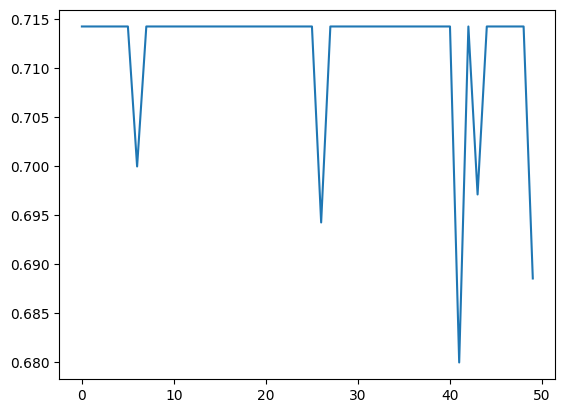

In [49]:
plt.plot(range(0, len(search_bayes_tree[0].cv_results_['mean_test_score'])), search_bayes_tree[0].cv_results_['mean_test_score'])

In [ ]:
grid_log_reg = {
    'classifier__C': np.logspace(-4, 4, 50),
    'classifier__l1_ratio': np.linspace(0, 1, 50)
}

grid_tree = {
    'classifier__max_depth': np.concatenate(([None], range(5, 100, 5))),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(2, 50, 2)),
    'classifier__max_leaf_nodes': np.concatenate(([None], range(30, 330, 30))),
    'classifier__ccp_alpha': np.logspace(-3, 3, 50)
}

grid_forest = {
    'classifier__max_depth': np.concatenate(([None], range(1, 11, 1))),
    'classifier__min_samples_split': list(range(2, 10)),
    'classifier__min_samples_leaf': list(range(2, 10, 1)),
    'classifier__max_leaf_nodes': np.concatenate(([None], range(2, 50, 1))),
    'classifier__ccp_alpha': np.logspace(-3, 2, 50),
    'classifier__bootstrap': [True, False],
    'classifier__warm_start': [True, False]
}

In [ ]:
from skopt.space import Real, Integer
from skopt.utils import use_named_args
space  = [Integer(1, 5, name='max_depth'),
          Real(10**-3, 10**2, "log-uniform", name='learning_rate'),
          Integer(2, 100, name='min_samples_split'),
          Integer(1, 100, name='min_samples_leaf')]

def objective(params):
    